<a href="https://colab.research.google.com/github/TimilsinaSushil/Thesis/blob/main/QC5_4500(Improving_K_fold_validation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install torch==1.3.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
# !pip install inltk
# !pip install nepali-stemmer
from inltk.inltk import setup
from inltk.inltk import tokenize
from inltk.inltk import get_embedding_vectors
from nepali_stemmer.stemmer import NepStemmer
# setup('ne')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('QSN.csv')

Saving QSN.csv to QSN (1).csv


['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']


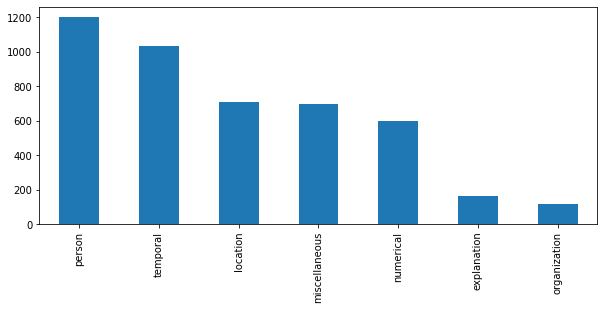

In [ ]:
#coarse type filtering
df=df[df['CoarseType'].isin(['location','temporal','numerical','person','organization','explanation','miscellaneous'])]
coarse_type=df['CoarseType'].unique()
# print(coarse_type)
print(coarse_type)
plt.figure(figsize=(10,4))
df.CoarseType.value_counts().plot(kind='bar');


**Text Preprocessig**

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#removing text inside brackets and quotes
import re
def removeTextInsideQuotesAndBrackets(text):
  text=re.sub("[\(\[].*?[\)\]]", "", text)
  text=re.sub("\'.*?\'","",text)
  text=re.sub('\".*?\"',"",text)
  return text

In [ ]:
def removeKo(text):
  words= text.split()
  text=[]
  for word in words:
    length=len(word)
    if(length > 2):
      if(word[-2]=='क' and word[-1]=='ो'):
        if(word!='कसको'):
          word= word[:length-2]
    text.append(word)
  text=' '.join([word for word in text])
  # print(text)
  return text




In [ ]:
def preprocessing(questions):
  questions=questions.apply(removeTextInsideQuotesAndBrackets)
  # questions = questions.apply(removeKo)
  #tokenization
  questions= questions.apply(lambda x: tokenize(x,'ne'))
  #removing duplicates
  questions= questions.apply(lambda x: list(dict.fromkeys(x)))
  
  questions=questions.apply(lambda x: ' '.join(x).replace('▁','').split())
  questions=questions.apply(lambda x: ' '.join(x))

  #removing numbers
  questios=questions.apply(lambda x: ''.join(c for c in x if not c.isdigit()))
  #removing punctuation
  punctuation=['!','"','#','$','&',"'",'(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[',"]",'^','_','`','{','|','}','~']
  questions = questions.apply(lambda x: ''.join(c for c in x if c not in punctuation))

  #removing stopwords
  WHWORDS = ['कुन','कहिले','के','कति','को','कसले','कहाँ','कसलाई','कसको','कस्तो','कति','कसरी','किन','कता']
  STOPWORDS = stopwords.words('nepali')
  # Removig WH words from STOPWORDS
  for word in WHWORDS:
    if word in STOPWORDS: STOPWORDS.remove(word)

  STOPWORDS=set(STOPWORDS)
  def clean_text(text):
      text=' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
      return text
  questions = questions.apply(clean_text)
  return questions



In [ ]:
#stemmig
# nepstem = NepStemmer()
# df['Questions'] = df['Questions'].apply(nepstem.stem)
# df.head(10)

In [ ]:
df['Questions'] = preprocessing(df['Questions'])

df.head()



,Questions,Answer,CoarseType,FineType,WhWord,Domain
0,नेपाली क्रिकेट टिम क्याप्टेन ज्ञानेन्द्र मल्ल ...,वि.सं. २०७६ कार्तिक १३,temporal,date,कहिले,Sports
1,फ्रान्स को लियोन सम्पन्न महिला विश्वकप फुटबल २...,अमेरिका,location,country,कसले,Sports
2,विश्व शान्ति सू चा ंक २०१९ नेपाल कति औ स्थानमा,७६ औ स्थानमा,numerical,rank,कति,Miscellaneous
3,फलफूल को बोट रु दश नोट कार्यक्रमको सुरुवात कुन...,"इच्छाकामना गाउँपालिका, चितवन",location,city,कुन,Politics
4,माथिल्लो त्रिशुली थ्री जल विध ुत आयोजना को विध...,वि.स. २०७६ जेठ ०२,temporal,date,कहिले,Miscellaneous


**Decleration**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier;
from sklearn.linear_model import LogisticRegression
TEST_SIZE=0.30
from sklearn.model_selection import StratifiedKFold
N_FOLD = 10

***K Fold Coarse Model***

In [ ]:
def kFoldCoarseModel(algorithm):
  from sklearn.metrics import confusion_matrix
  import random 

  X = df.Questions
  y = df.CoarseType

  # Splitting test set
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) 

  metrics = []
  skf= StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=1)
  X=np.array(X_train)
  y=np.array(y_train)

 # Defining Model
  if(algorithm=='nb'):
    model = Pipeline([('vect', CountVectorizer()),
              ('tfidf', TfidfTransformer()),
              ('clf', MultinomialNB()),
              ]) 
  elif(algorithm=="svm"):
    model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(SVC(C=1, kernel='sigmoid'))),    #Non linear svm
              ])
    
    #gaussian
    #sigmoid
  #model defination finished
  

  # K fold cross validation
  for train_index, validation_index in skf.split(X, y):
      print("TRAIN:", train_index, "VALIDATION:", validation_index)
      X_train, X_validation = X[train_index], X[validation_index]
      y_train, y_validation = y[train_index], y[validation_index]
      # set parameter
      # model.set_params(max_iterations=10)
  #   # train the model
      model.fit(X_train,y_train)
  #   # validate the model 
      y_pred_class_for_validation = model.predict(X_validation)
      metrics.append(accuracy_score(y_validation, y_pred_class_for_validation))
      # print(classification_report(y_test, y_pred_class,target_names=coarse_type))
      

  


  metrics = np.array(metrics)
  print('Validation Accuracy for each Iteration',metrics)
  print('Mean accuracy for validation set: ', np.mean(metrics, axis=0))
  print('Std for accuracy: ', np.std(metrics, axis=0))
  print('---------------------------------------------------------------------------------')

  y_pred = model.predict(X_test)

  test_accuracy = accuracy_score(y_pred, y_test)
  print('Test Accuracy : %s' % test_accuracy)
  print(classification_report(y_test, y_pred,target_names=coarse_type))

  cf_matrix = confusion_matrix(y_test, y_pred, labels=coarse_type)
  # print(cf_matrix)

  import seaborn as sns
  plt.figure(figsize=(8,7))
  actual_data= ['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']
  predicted_data= ['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']
  cm = confusion_matrix(actual_data, predicted_data)
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted Intent')
  ax.set_ylabel('Actual Intent')
  ax.xaxis.set_ticklabels(['TEM','LOC','NUM','PER','ORG','EXP','MISC'])
  ax.yaxis.set_ticklabels(['TEM','LOC','NUM','PER','ORG','EXP','MISC'])
  plt.show()
  
  return model


TRAIN: [   0    1    2    3 ... 3609 3610 3611 3612] VALIDATION: [   4   22   26   45 ... 3586 3594 3597 3602]
TRAIN: [   0    2    3    4 ... 3609 3610 3611 3612] VALIDATION: [   1   12   49   70 ... 3580 3581 3591 3606]
TRAIN: [   0    1    2    3 ... 3608 3609 3611 3612] VALIDATION: [   7    8    9   13 ... 3585 3595 3607 3610]
TRAIN: [   0    1    2    4 ... 3608 3610 3611 3612] VALIDATION: [   3    5   11   30 ... 3579 3584 3598 3609]
TRAIN: [   0    1    2    3 ... 3608 3609 3610 3612] VALIDATION: [  15   27   43   56 ... 3556 3577 3599 3611]
TRAIN: [   0    1    2    3 ... 3609 3610 3611 3612] VALIDATION: [  18   21   23   25 ... 3564 3575 3588 3596]
TRAIN: [   0    1    2    3 ... 3609 3610 3611 3612] VALIDATION: [  17   28   34   37 ... 3576 3582 3583 3603]
TRAIN: [   0    1    3    4 ... 3609 3610 3611 3612] VALIDATION: [   2   16   24   36 ... 3587 3589 3601 3604]
TRAIN: [   0    1    2    3 ... 3609 3610 3611 3612] VALIDATION: [   6   14   38   41 ... 3563 3567 3592 3608]
T

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


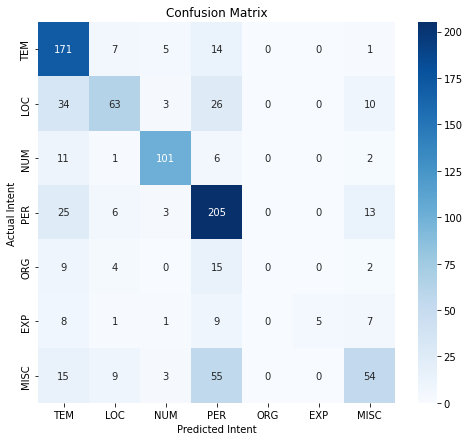

In [ ]:
k_fold_nb_model= kFoldCoarseModel('nb')

TRAIN: [   0    1    2    3 ... 3609 3610 3611 3612] VALIDATION: [   8   25   27   33 ... 3580 3599 3602 3606]
TRAIN: [   0    3    4    5 ... 3607 3609 3610 3611] VALIDATION: [   1    2   31   91 ... 3583 3603 3608 3612]
TRAIN: [   0    1    2    3 ... 3608 3609 3611 3612] VALIDATION: [   6   38   68   70 ... 3579 3585 3605 3610]
TRAIN: [   0    1    2    3 ... 3609 3610 3611 3612] VALIDATION: [  12   13   14   30 ... 3586 3591 3592 3593]
TRAIN: [   0    1    2    5 ... 3609 3610 3611 3612] VALIDATION: [   3    4   11   24 ... 3566 3569 3577 3596]
TRAIN: [   1    2    3    4 ... 3608 3610 3611 3612] VALIDATION: [   0    9   15   19 ... 3555 3600 3601 3609]
TRAIN: [   0    1    2    3 ... 3608 3609 3610 3612] VALIDATION: [   5   16   34   39 ... 3588 3589 3607 3611]
TRAIN: [   0    1    2    3 ... 3609 3610 3611 3612] VALIDATION: [  10   17   35   44 ... 3560 3568 3581 3584]
TRAIN: [   0    1    2    3 ... 3609 3610 3611 3612] VALIDATION: [  20   22   26   29 ... 3590 3594 3598 3604]
T

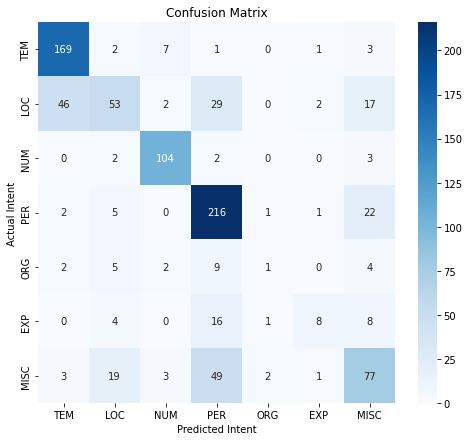

In [ ]:
k_fold_svm_model= kFoldCoarseModel('svm')

***Train Test split coarse model***

In [ ]:
def coarseModel(algorithm):
  X = df.Questions
  y = df.CoarseType

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state = 42) 

  if(algorithm=='nb'):
    model = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ]) 
  elif(algorithm=='sgd'):
    model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None, shuffle=True)), #Equivalent to linear svm
               ])
  elif(algorithm=="svm"):
    model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(SVC(C=1, kernel='sigmoid'))),    #Non linear svm
               ])
    # model = Pipeline([('vect', CountVectorizer()),
    #           ('tfidf', TfidfTransformer()),
    #           ('clf', LinearSVC(loss='hinge', penalty='l2', random_state=None, max_iter=5,tol=0.0001)), #Linear  svm
    #           ])
  else:
    model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
  

  model.fit(X_train, y_train)
  # %time

  y_pred = model.predict(X_test)

  model_accuracy = accuracy_score(y_pred, y_test)
  print('Accuracy : %s' % model_accuracy)
  print(classification_report(y_test, y_pred,target_names=coarse_type))
  return model




In [ ]:
nb_model=coarseModel('nb');

Accuracy : 0.6497050147492626
               precision    recall  f1-score   support

     temporal       1.00      0.18      0.30        45
     location       0.60      0.41      0.49       203
    numerical       0.66      0.38      0.48       219
       person       0.80      0.76      0.78       176
 organization       0.00      0.00      0.00        40
  explanation       0.63      0.83      0.72       368
miscellaneous       0.62      0.88      0.72       305

     accuracy                           0.65      1356
    macro avg       0.62      0.49      0.50      1356
 weighted avg       0.64      0.65      0.62      1356



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
sgd_model=coarseModel('sgd')

Accuracy : 0.7050147492625368
               precision    recall  f1-score   support

     temporal       0.55      0.27      0.36        45
     location       0.59      0.35      0.44       203
    numerical       0.61      0.48      0.54       219
       person       0.87      0.92      0.90       176
 organization       0.55      0.15      0.24        40
  explanation       0.67      0.87      0.76       368
miscellaneous       0.77      0.92      0.84       305

     accuracy                           0.71      1356
    macro avg       0.66      0.56      0.58      1356
 weighted avg       0.69      0.71      0.68      1356



In [ ]:
svm_model=coarseModel('svm')

Accuracy : 0.6873156342182891
               precision    recall  f1-score   support

     temporal       0.39      0.29      0.33        45
     location       0.50      0.37      0.43       203
    numerical       0.54      0.47      0.50       219
       person       0.89      0.90      0.90       176
 organization       0.38      0.07      0.12        40
  explanation       0.67      0.82      0.74       368
miscellaneous       0.80      0.91      0.86       305

     accuracy                           0.69      1356
    macro avg       0.60      0.55      0.55      1356
 weighted avg       0.66      0.69      0.67      1356



In [ ]:
# logreg_model=coarseModel('logreg')

**Predictions**

In [ ]:
unseen_questions=[["सन् २०२० मार्चमा प्रदान गरिएको इन्टरनेसनल कम्युनिकेसन अवार्ड बाट सम्मानित व्यत्तित्व को हनुहुन्छ ? "],["नेपाल न्यून आय भएका मुलुकबाट न्यून मध्यम आय भएका मुलुकको सूचीमा कहिले स्तरोन्नति भएको हो ? "],
                      ["वि.सं. २०७७ असार २३ सरकारले नेपाल प्रहरी महानिरीक्षक (आईजीपी) मा कसलाई नियुक्त गर्यो ?"],["हाल रेडियो नेपालबाट कति भाषामा समाचार प्रसारण हुने गर्छ ?"],
                      ["समाजसेवी तथा शिक्षाविद् अङ्गुरबाबा जोशीको निधन कहिले भएको हो ?"],["सन् २०२० जुनमा सुरक्षा परिषदको अस्थायी सदस्यमा निर्वाचित हुन सफल राष्ट्र कुन कुन हुन ?"],
                      ["'एक वडा एक व्यायामशाला' निमाणको योजना अघि बढाउने स्थानीय तह कुन हो ?"],["बालबालिकाको क्षेत्रमा काम गर्ने अन्तर्राष्ट्रिय संस्था किवानिज इन्टरनेसनलको एसिया प्यासिफिक सम्मेलन हालै कहाँ सम्पन्न भयो ?"],
                      ["लोकसेवा आयोग विधेयक प्रतिनिधिसभाबाट कहिले पारित भएको हो ?"],["नेपालमा कृषक परिचयपत्र वितरण गर्ने कार्य कुन जिल्लाबाट सुरु गरिएको हो ?"],
                      ["विश्व बैंकद्वारा विसं २०७६ कात्तिक ७ मा सार्वजनिक डुइङ बिजनेस प्रतिवेदन २०२० अनुसार नेपाल कतिऔं स्थानमा रहेको छ ?"],['नेपाली पोर्टको शुभारम्भ कहिले भएको हो ?'],
                      ["सन्  २०१९/२० को विस्डन क्रिकेटर अफ द इयरको उपाधि जित्ने क्रिकेटर को हुन ?"],['सबै जिल्लामा स्वास्थ्य विमा सेवा लागु गर्ने पहिलो प्रदेश कुन हो ?']]
dfq=pd.DataFrame(unseen_questions,columns=['questions'])

dfq['questions']= preprocessing(dfq['questions'])
validation_questions=dfq['questions'].to_numpy()


# print("Naive Bayes Classifier \n")
# for question in validation_questions:
#   question=[question]
#   test_pred= nb_model.predict(question)
#   print(question[0] +' : ' + test_pred[0])
# print('\n')


# print("SGDC Classifier \n")
# for question in validation_questions:
#   test_pred= sgd_model.predict(question)
#   print(question[0] +' : ' + test_pred[0])
# print('\n')

print("Support Vector Machine(Train/Test split) \n")
for question in validation_questions:
  question=[question]
  test_pred= svm_model.predict(question)
  print(question[0] +' : ' + test_pred[0])
print('\n')


print("Support Vector Machine(K fold cross validation) \n")
for question in validation_questions:
  question=[question]
  test_pred= k_fold_svm_model.predict(question)
  print(question[0] +' : ' + test_pred[0])
print('\n')

# print("Logistic Regression \n")
# for question in validation_questions:
#   test_pred= logreg_model.predict(question)
#   print(question[0] +' : ' + test_pred[0])


Support Vector Machine(Train/Test split) 

सन् २०२० मार्च प्रदान गरिएको इन्टरनेसनल कम्युन िक ेसन अवार्ड बाट सम्मानित व्य त्ति त्व को हन ुहुन्छ : miscellaneous
नेपाल न्यून आय भएका मुलुक बाट मध्यम मुलुकको सूची कहिले स्तर ो न्न ति : temporal
वि सं २०७७ असार २३ सरकार नेपाल प्रहरी महानिरीक्षक कस नियुक्त गर्यो : person
हाल रेडियो नेपाल बाट कति भाषामा समाचार प्रसारण : numerical
समाजसेवी शिक्षा विद् अङ्ग ुर बाबा जोशी को निधन कहिले : temporal
सन् २०२० सुरक्षा परिषद को अस्थायी सदस्य निर्वाचित सफल राष्ट्र कुन : person
ण को योजना अघि बढाउने स्थानीय तह कुन : location
बालबालिका को क्षेत्रमा काम अन्तर्राष्ट्रिय संस्था वा निज इन्टरनेसनल एसिया प्यास िफ िक सम्मेलन हालै कहाँ सम्पन्न भयो : temporal
लोक सेवा आयोग विधेयक प्रतिनिधिसभा बाट कहिले पारित : temporal
नेपालमा कृषक परिचय पत्र वितरण कार्य कुन जिल्लाबाट सुरु गरिएको : temporal
विश्व बैंक द्वारा विसं २०७६ कात्तिक ७ सार्वजनिक डु इ ङ बिज नेस प्रतिवेदन २०२० नेपाल कति स्थानमा : numerical
नेपाली पोर्ट को शुभ ारम्भ कहिले : temporal
सन् २०१९ २० को वि स् डन क्र

**Fine Type Classification**

In [ ]:
def kFoldFineModel(type,fine,algorithm):
  from sklearn.metrics import confusion_matrix

  c_type=type
  f_type=c_type['FineType'].unique()
  print(f_type)
  X_fine = c_type.Questions
  Y_fine = c_type.FineType
  Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_fine, Y_fine, test_size=TEST_SIZE, random_state = 42) 
  
  metrics = []
  skf= StratifiedKFold(n_splits=N_FOLD, shuffle=True)
  X=np.array(Xf_train)
  y=np.array(yf_train)

  # Defining Model
  if(algorithm=='nb'):
    model = Pipeline([('vect', CountVectorizer()),
              ('tfidf', TfidfTransformer()),
              ('clf', MultinomialNB()),
              ]) 
  elif(algorithm=="svm"):
    model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(SVC(C=1, kernel='sigmoid'))),    #Non linear svm
              ])
  #model defination finished

  # K fold cross validation
  for train_index, validation_index in skf.split(X, y):
      print("TRAIN:", train_index, "VALIDATION:", validation_index)
      X_train, X_validation = X[train_index], X[validation_index]
      y_train, y_validation = y[train_index], y[validation_index]
  #   # train the model
      model.fit(X_train,y_train)
  #   # validate the model 
      y_pred_class_for_validation = model.predict(X_validation)
      metrics.append(accuracy_score(y_validation, y_pred_class_for_validation))
      # print(classification_report(y_test, y_pred_class,target_names=coarse_type))
      

  


  metrics = np.array(metrics)
  print('Validation Accuracy for each Iteration',metrics)
  print('Mean accuracy for validation set: ', np.mean(metrics, axis=0))
  print('Std for accuracy: ', np.std(metrics, axis=0))
  print('---------------------------------------------------------------------------------')

  yf_pred = model.predict(Xf_test)

  test_accuracy = accuracy_score(yf_pred, yf_test)
  print('Test Accuracy : %s' % test_accuracy)
  print(classification_report(yf_test, yf_pred,target_names=f_type))
  cf_matrix = confusion_matrix(yf_test, yf_pred, labels=f_type)

# for confusion matrix can be commented later
  import seaborn as sns
  plt.figure(figsize=(8,7))
  if(fine=='person'):
    actual_data= ['individual','inventor','appellation','discoverer']
    predicted_data= ['individual','inventor','appellation','discoverer']
  elif(fine=='temporal'):
    actual_data= ['date','duration','day','year','range']
    predicted_data= ['date','duration','day','year','range']
  elif(fine=='location'):
    actual_data= ['country','city','district','river','region','state','address']
    predicted_data= ['country','city','district','river','region','state','address']
  elif(fine=='numerical'):
    actual_data= ['count','percentage','rank','length','money','temperture']
    predicted_data= ['count','percentage','rank','length','money','temperture']
  elif(fine=='organization'):
    actual_data= ['sport-team','bank','company']
    predicted_data= ['sport-team','bank','company']
  elif(fine=='explanation'):
    actual_data= ['description','method','reason']
    predicted_data= ['description','method','reason']
  elif(fine=='explanation'):
    actual_data= ['material','animal','device','sport','book','planet','color','religion','disease','language']
    predicted_data= ['material','animal','device','sport','book','planet','color','religion','disease','language']

  cm = confusion_matrix(actual_data, predicted_data)
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

  if(type=='person'):
    ax.xaxis.set_ticklabels(['individual','inventor','appellation','discoverer'])
    ax.yaxis.set_ticklabels(['individual','inventor','appellation','discoverer'])
  elif(type=='temporal'):
    ax.xaxis.set_ticklabels(['date','duration','day','year','range'])
    ax.yaxis.set_ticklabels(['date','duration','day','year','range'])
  elif(type=='location'):
    ax.xaxis.set_ticklabels(['country','city','district','river','region','state','address'])
    ax.yaxis.set_ticklabels(['country','city','district','river','region','state','address'])
  elif(type=='numerical'):
    ax.xaxis.set_ticklabels(['count','percentage','rank','length','money','temperture'])
    ax.yaxis.set_ticklabels(['count','percentage','rank','length','money','temperture'])
  elif(type=='organization'):
    ax.xaxis.set_ticklabels(['sport-team','bank','company'])
    ax.yaxis.set_ticklabels(['sport-team','bank','company'])
  elif(type=='explanation'):
    ax.xaxis.set_ticklabels(['description','method','reason'])
    ax.yaxis.set_ticklabels(['description','method','reason'])
  elif(type=='explanation'):
    ax.xaxis.set_ticklabels(['material','animal','device','sport','book','planet','color','religion','disease','language'])
    ax.yaxis.set_ticklabels(['material','animal','device','sport','book','planet','color','religion','disease','language'])
  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted Intent')
  ax.set_ylabel('Actual Intent')
  plt.show()

  return model

In [ ]:
#Model Function
def fineModel(type,algorithm):
  c_type=type
  f_type=c_type['FineType'].unique()
  # f_type=['individual','inventor','discoverer','appellation','group','position','other']
  print(f_type)
  #splittig
  X_fine = c_type.Questions
  Y_fine = c_type.FineType
  Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_fine, Y_fine, test_size=TEST_SIZE, random_state = 42) 

  #Fine type model

  # model = Pipeline([('vect', CountVectorizer()),
  #                 ('tfidf', TfidfTransformer()),
  #                 ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
  #               ])
  model = Pipeline([('vect', CountVectorizer()),
              ('tfidf', TfidfTransformer()),
              ('clf', OneVsRestClassifier(SVC(C=1, kernel='sigmoid'))),    #Non linear svm
              ])
  model.fit(Xf_train,yf_train )

  # %time

  yf_pred = model.predict(Xf_test)
  print(np.unique(yf_pred))

  fine_accuracy = accuracy_score(yf_pred, yf_test)
  print('Accuracy : %s' % fine_accuracy)
  # print(classification_report(yf_test, yf_pred,target_names=f_type))
  return model



['individual' 'inventor' 'discoverer' 'appellation']
TRAIN: [  0   1   2   5 ... 829 830 831 832] VALIDATION: [  3   4  12  51 ... 811 820 833 834]
TRAIN: [  0   1   2   3 ... 830 832 833 834] VALIDATION: [  6  17  28  29 ... 767 796 799 831]
TRAIN: [  0   1   2   3 ... 831 832 833 834] VALIDATION: [  7  18  26  32 ... 813 818 826 829]
TRAIN: [  0   1   2   3 ... 831 832 833 834] VALIDATION: [ 20  27  30  48 ... 785 792 804 816]


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  UserWarning,


TRAIN: [  0   1   2   3 ... 829 831 833 834] VALIDATION: [ 15  31  39  54 ... 815 817 830 832]
TRAIN: [  0   1   3   4 ... 831 832 833 834] VALIDATION: [  2   9  25  36 ... 789 822 824 825]
TRAIN: [  0   1   2   3 ... 831 832 833 834] VALIDATION: [  5   8  13  19 ... 800 802 805 821]
TRAIN: [  0   1   2   3 ... 831 832 833 834] VALIDATION: [ 10  11  14  37 ... 781 782 784 827]
TRAIN: [  0   2   3   4 ... 831 832 833 834] VALIDATION: [  1  16  21  22 ... 812 814 819 823]
TRAIN: [  1   2   3   4 ... 831 832 833 834] VALIDATION: [  0  34  41  73 ... 750 756 807 828]
Validation Accuracy for each Iteration [0.928571 0.952381 0.928571 0.940476 0.964286 0.963855 0.963855 0.963855 0.927711 0.939759]
Mean accuracy for validation set:  0.9473321858864028
Std for accuracy:  0.015248772128904747
---------------------------------------------------------------------------------
Test Accuracy : 0.946927374301676
              precision    recall  f1-score   support

  individual       0.00      0.00 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: ignored

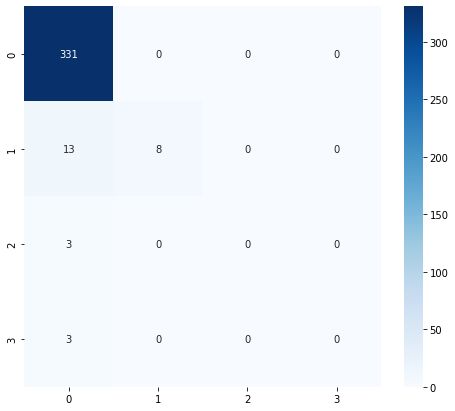

In [ ]:
#person/Svm
c_type=df[df['CoarseType']=='person']
c_type= c_type[c_type['FineType'].isin(['individual','inventor','appellation','discoverer'])]
# person_model=fineModel(c_type,'svm')
person_model=kFoldFineModel(c_type,'person','svm')

['bank' 'sport-team' 'company']
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 19 20 22 23 24 25 26 27 28 29 30 32 33 34 35 36 37 38 39 40] VALIDATION: [ 5 17 18 21 31]
TRAIN: [ 0  1  2  5  6  7  8 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] VALIDATION: [ 3  4  9 10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25 26 28 29 30 31 32 33 34 35 36 37 38] VALIDATION: [24 27 39 40]
TRAIN: [ 0  1  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 33 34 35 36 37 39 40] VALIDATION: [ 2  7 32 38]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 16 17 18 19 21 22 23 24 25 26 27 28 29 30 31 32 34 35 36 37 38 39 40] VALIDATION: [14 15 20 33]
TRAIN: [ 2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 27 28 29 30 31 32 33 34 35 36 37 38 39 40] VALIDATION: [ 0  1  8 26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  UserWarning,


ValueError: ignored

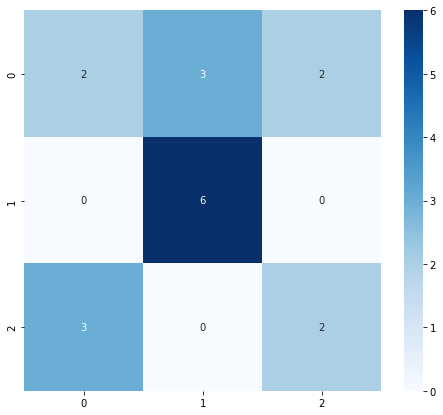

In [ ]:
#organization/Svm
c_type=df[df['CoarseType']=='organization']
c_type= c_type[c_type['FineType'].isin(['sport-team','bank','company'])]
# organization_model=fineModel('person','svm')
organization_model=kFoldFineModel(c_type,'organization','svm')

In [ ]:
#location/Svm
c_type=df[df['CoarseType']=='location']
c_type= c_type[c_type['FineType'].isin(['country','city','district','river','region','state','address'])]
# location_model=fineModel(c_type,'svm')
location_model=kFoldFineModel(c_type,'svm')

TypeError: ignored

['date' 'duration' 'day' 'year' 'range']
TRAIN: [  0   2   3   4 ... 698 699 700 701] VALIDATION: [  1   6  16  34 ... 675 682 695 702]


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  UserWarning,


TRAIN: [  0   1   2   3 ... 698 700 701 702] VALIDATION: [  4   8  26  27 ... 684 687 688 699]
TRAIN: [  0   1   2   3 ... 698 699 700 702] VALIDATION: [ 15  20  32  37 ... 685 692 697 701]
TRAIN: [  0   1   2   3 ... 699 700 701 702] VALIDATION: [ 30  40  66  74 ... 645 655 669 681]
TRAIN: [  0   1   2   4 ... 699 700 701 702] VALIDATION: [  3   7  10  19 ... 660 663 670 676]
TRAIN: [  0   1   2   3 ... 699 700 701 702] VALIDATION: [ 11  25  29  57 ... 674 680 691 696]
TRAIN: [  0   1   2   3 ... 699 700 701 702] VALIDATION: [ 12  13  14  18 ... 658 667 679 693]
TRAIN: [  0   1   3   4 ... 699 700 701 702] VALIDATION: [  2   5  35  39 ... 639 653 656 686]
TRAIN: [  1   2   3   4 ... 699 700 701 702] VALIDATION: [  0  21  24  43 ... 664 689 690 698]
TRAIN: [  0   1   2   3 ... 698 699 701 702] VALIDATION: [  9  17  38  71 ... 677 683 694 700]
Validation Accuracy for each Iteration [0.943662 0.929577 0.929577 0.942857 0.928571 0.928571 0.928571 0.942857 0.942857 0.942857]
Mean accuracy 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: ignored

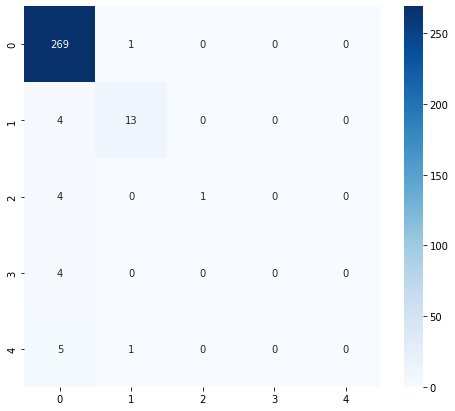

In [ ]:
#temporal/Svm
c_type=df[df['CoarseType']=='temporal']
c_type= c_type[c_type['FineType'].isin(['date','duration','day','year','range'])]
# temporal_model=fineModel(c_type,'svm')
temporal_model=kFoldFineModel(c_type,'temporal','svm')

In [ ]:
#numerical/Svm
c_type=df[df['CoarseType']=='numerical']
c_type= c_type[c_type['FineType'].isin(['count','percentage','rank','length','money','temperture'])]
# numerical_model=fineModel(c_type,'svm')
numerical_model=kFoldFineModel(c_type,'svm')

['rank' 'money' 'percentage' 'count' 'length' 'temperture']
TRAIN: [  0   1   3   4 ... 363 364 365 366] VALIDATION: [  2   5  17  22  35  46  49  53  59  66  71  79 112 130 131 162 171 176 185 205 209 213 221 238 239 251 257 270 291
 304 307 315 332 335 336 339 349]
TRAIN: [  0   1   2   3 ... 362 363 365 366] VALIDATION: [  4   6  23  29  41  43  47  63  65  70  77  85  87 129 133 135 139 144 158 179 190 208 225 230 241 252 258 272 286
 289 290 298 310 311 340 359 364]
TRAIN: [  0   1   2   3 ... 363 364 365 366] VALIDATION: [  7   8  24  38  56  68  84  86 103 114 116 119 122 123 141 142 151 166 183 188 197 204 224 227 235 243 265 269 285
 293 305 308 309 313 314 319 326]
TRAIN: [  1   2   3   4 ... 363 364 365 366] VALIDATION: [  0   9  20  69  73  88  93 104 109 110 111 136 145 165 173 178 180 203 210 211 218 219 223 228 236 242 246 271 281
 283 288 321 323 342 347 350 355]
TRAIN: [  0   2   3   4 ... 363 364 365 366] VALIDATION: [  1  12  13  14  28  34  36  57  80  82  94  99 10

In [ ]:
#explanation/Svm
c_type=df[df['CoarseType']=='explanation']
c_type= c_type[c_type['FineType'].isin(['description','method','reason'])]
# explanation_model=fineModel(c_type,'svm')
explanation_model=kFoldFineModel(c_type,'svm')

['description' 'reason' 'method']
TRAIN: [  0   1   3   4 ... 108 109 110 111] VALIDATION: [  2   8  11  12  15  35  54  63  71  72  90 105]
TRAIN: [  0   1   2   3 ... 108 109 110 111] VALIDATION: [10 24 27 31 36 68 76 81 83 85 89 96]
TRAIN: [  0   1   2   3 ... 108 109 110 111] VALIDATION: [ 23  40  43  57  62  86  87  94  97  98 106]
TRAIN: [  1   2   3   4 ... 108 109 110 111] VALIDATION: [ 0  5 16 17 44 46 52 53 60 74 93]
TRAIN: [  0   1   2   3 ... 106 109 110 111] VALIDATION: [  4   7   9  32  41  51  59  65 102 107 108]


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


TRAIN: [  0   1   2   3 ... 108 109 110 111] VALIDATION: [ 25  26  29  34  37  39  56  61  69  84 103]
TRAIN: [  0   1   2   3 ... 107 108 110 111] VALIDATION: [ 21  22  30  45  49  58  64  67  77  79 109]
TRAIN: [  0   1   2   3 ... 107 108 109 110] VALIDATION: [  6  38  42  55  82  92  95  99 101 104 111]
TRAIN: [  0   2   3   4 ... 108 109 110 111] VALIDATION: [  1  14  18  19  33  47  48  70  73  88 100]
TRAIN: [  0   1   2   4 ... 107 108 109 111] VALIDATION: [  3  13  20  28  50  66  75  78  80  91 110]
Validation Accuracy for each Iteration [1.       0.916667 1.       0.909091 1.       1.       1.       1.       1.       1.      ]
Mean accuracy for validation set:  0.9825757575757577
Std for accuracy:  0.034889633150513515
---------------------------------------------------------------------------------
Test Accuracy : 0.8571428571428571
              precision    recall  f1-score   support

 description       0.85      1.00      0.92        41
      reason       1.00      0.50 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#miscelleneous/Svm
c_type=df[df['CoarseType']=='miscellaneous']
c_type= c_type[c_type['FineType'].isin(['material','animal','device','sport','book','planet','color','religon','disease','language'])]
# miscellaneous_model=fineModel(c_type,'svm')
miscellaneous_model=kFoldFineModel(c_type,'svm')

['language' 'device' 'color' 'planet' 'book' 'sport' 'animal' 'material' 'disease']
TRAIN: [  0   1   2   3 ... 144 145 147 148] VALIDATION: [ 20  27  38  42  49  60  73  89 103 110 117 118 124 132 146]
TRAIN: [  0   1   2   3 ... 145 146 147 148] VALIDATION: [ 15  22  34  66  70  76  80  87  88  93  99 104 141 143 144]
TRAIN: [  0   1   2   3 ... 145 146 147 148] VALIDATION: [  8  10  36  56  62  64  67  74  77  78  86  95 102 108 137]
TRAIN: [  0   1   2   3 ... 145 146 147 148] VALIDATION: [  4   7   9  14  17  43  68  82  85 100 101 119 121 139 142]
TRAIN: [  0   3   4   5 ... 145 146 147 148] VALIDATION: [  1   2  11  18  25  35  37  39  44  57  65  72  75 114 123]
TRAIN: [  0   1   2   3 ... 144 145 146 147] VALIDATION: [ 12  33  47  55  83  90  92  98 115 116 122 126 127 130 148]


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  UserWarning,


TRAIN: [  0   1   2   4 ... 145 146 147 148] VALIDATION: [  3  19  24  29  48  54  59  61  71  81 107 109 120 128 138]
TRAIN: [  0   1   2   3 ... 144 146 147 148] VALIDATION: [  6  13  16  26  30  41  45  46  69  79  91 106 134 136 145]
TRAIN: [  1   2   3   4 ... 145 146 147 148] VALIDATION: [  0   5  21  31  32  50  51  53  94  97 105 112 125 131 135]
TRAIN: [  0   1   2   3 ... 144 145 146 148] VALIDATION: [ 23  28  40  52  58  63  84  96 111 113 129 133 140 147]
Validation Accuracy for each Iteration [0.8      0.666667 0.6      0.733333 0.6      0.733333 0.733333 0.6      0.533333 0.571429]
Mean accuracy for validation set:  0.6571428571428571
Std for accuracy:  0.08389605922112472
---------------------------------------------------------------------------------
Test Accuracy : 0.49230769230769234
              precision    recall  f1-score   support

    language       0.75      0.43      0.55        14
      device       0.50      0.20      0.29         5
       color       1.00

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Overall Prediction**

In [ ]:
unseen_questions=[["सन् २०२० मार्चमा प्रदान गरिएको इन्टरनेसनल कम्युनिकेसन अवार्ड बाट सम्मानित व्यत्तित्व को हनुहुन्छ ? "],["नेपाल न्यून आय भएका मुलुकबाट न्यून मध्यम आय भएका मुलुकको सूचीमा कहिले स्तरोन्नति भएको हो ? "],
                      ["वि.सं. २०७७ असार २३ सरकारले नेपाल प्रहरी महानिरीक्षक (आईजीपी) मा कसलाई नियुक्त गर्यो ?"],["हाल रेडियो नेपालबाट कति भाषामा समाचार प्रसारण हुने गर्छ ?"],
                      ["समाजसेवी तथा शिक्षाविद् अङ्गुरबाबा जोशीको निधन कहिले भएको हो ?"],["सन् २०२० जुनमा सुरक्षा परिषदको अस्थायी सदस्यमा निर्वाचित हुन सफल राष्ट्र कुन कुन हुन ?"],
                      ["'एक वडा एक व्यायामशाला' निमाणको योजना अघि बढाउने स्थानीय तह कुन हो ?"],["बालबालिकाको क्षेत्रमा काम गर्ने अन्तर्राष्ट्रिय संस्था किवानिज इन्टरनेसनलको एसिया प्यासिफिक सम्मेलन हालै कहाँ सम्पन्न भयो ?"],
                      ["लोकसेवा आयोग विधेयक प्रतिनिधिसभाबाट कहिले पारित भएको हो ?"],["नेपालमा कृषक परिचयपत्र वितरण गर्ने कार्य कुन जिल्लाबाट सुरु गरिएको हो ?"],
                      ["विश्व बैंकद्वारा विसं २०७६ कात्तिक ७ मा सार्वजनिक डुइङ बिजनेस प्रतिवेदन २०२० अनुसार नेपाल कतिऔं स्थानमा रहेको छ ?"],['नेपाली पोर्टको शुभारम्भ कहिले भएको हो ?'],
                      ["सन्  २०१९/२० को विस्डन क्रिकेटर अफ द इयरको उपाधि जित्ने क्रिकेटर को हुन ?"],['सबै जिल्लामा स्वास्थ्य विमा सेवा लागु गर्ने पहिलो प्रदेश कुन हो ?']]
dfq=pd.DataFrame(unseen_questions,columns=['questions'])

dfq['questions']= preprocessing(dfq['questions'])
validation_questions=dfq['questions'].to_numpy()


print("SVM Model")
for question in validation_questions:
  question=[question]
  # test_pred= svm_model.predict(question)
  test_pred= k_fold_svm_model.predict(question)
  coarse_type=test_pred[0]
  if(coarse_type=='person'):
    fine_type=person_model.predict(question)
  elif(coarse_type=='organization'):
    fine_type=organization_model.predict(question)
  elif(coarse_type=='location'):
    fine_type=location_model.predict(question)
  elif(coarse_type=='temporal'):
    fine_type=temporal_model.predict(question)
  elif(coarse_type=='numerical'):
    fine_type=numerical_model.predict(question)
  elif(coarse_type=='explanation'):
    fine_type=explanation_model.predict(question)
  elif(coarse_type=='miscellaneous'):
    fine_type=miscellaneous_model.predict(question)
  else:
    print("Coarse type didn't match")

  print(question[0] +" "+ coarse_type+ " : " +fine_type[0])
print('\n')

SVM Model
सन् २०२० मार्च प्रदान गरिएको इन्टरनेसनल कम्युन िक ेसन अवार्ड बाट सम्मानित व्य त्ति त्व को हन ुहुन्छ miscellaneous : sport
नेपाल न्यून आय भएका मुलुक बाट मध्यम मुलुकको सूची कहिले स्तर ो न्न ति temporal : date
वि सं २०७७ असार २३ सरकार नेपाल प्रहरी महानिरीक्षक कस नियुक्त गर्यो person : individual
हाल रेडियो नेपाल बाट कति भाषामा समाचार प्रसारण numerical : count
समाजसेवी शिक्षा विद् अङ्ग ुर बाबा जोशी को निधन कहिले temporal : date
सन् २०२० सुरक्षा परिषद को अस्थायी सदस्य निर्वाचित सफल राष्ट्र कुन person : individual
ण को योजना अघि बढाउने स्थानीय तह कुन location : country
बालबालिका को क्षेत्रमा काम अन्तर्राष्ट्रिय संस्था वा निज इन्टरनेसनल एसिया प्यास िफ िक सम्मेलन हालै कहाँ सम्पन्न भयो temporal : date
लोक सेवा आयोग विधेयक प्रतिनिधिसभा बाट कहिले पारित temporal : date
नेपालमा कृषक परिचय पत्र वितरण कार्य कुन जिल्लाबाट सुरु गरिएको person : individual
विश्व बैंक द्वारा विसं २०७६ कात्तिक ७ सार्वजनिक डु इ ङ बिज नेस प्रतिवेदन २०२० नेपाल कति स्थानमा numerical : rank
नेपाली पोर्ट को शुभ ारम्भ क